In [1]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import re

In [2]:
def normalize_spaces(text):
    #spaces and Unicode-spaces and other non-alphabetical letters in the names of the nifti or xml files should be normalized
    #original problem: ROI names in the xml label files had several spaces/Unicode signs between words instead of one
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        normalized_text = text.replace('\xa0', ' ')
        normalized_text = re.sub(r'\s+', ' ', normalized_text).strip()
        return normalized_text.strip()
    return text

In [3]:
def prepare_effect_sizes_dataframe(effect_sizes_file_path, file_type, raw_roi_name_col, effect_size_col, diagnosis_col, target_atlas_name="neuromorphometrics"):
    
    #loads effectsizes from df for plotting on brains 
    #cleanes up the ROI names 
   
    try:
        if file_type == 'csv':
            df = pd.read_csv(effect_sizes_file_path)
        elif file_type == 'excel':
            df = pd.read_excel(effect_sizes_file_path)
        else:
            print(f"Error: wrong datatype '{file_type}'. Please use csv or Excel")
            return None

        #print(f"raw effect sizes loaded from : {effect_sizes_file_path}")

        required_cols = [raw_roi_name_col, effect_size_col, diagnosis_col]
        for col in required_cols:
            if col not in df.columns:
                print(f"Error: Column '{col}' not found in df")
                print(f"Available columns: {df.columns.tolist()}")
                return None

        df_filtered = df[df[raw_roi_name_col].astype(str).str.contains(target_atlas_name, na=False, case=False)]
        #print(f"Df filtered for:'{target_atlas_name}'; Original rows: {len(df)}, Filtered rows: {len(df_filtered)}")

        if df_filtered.empty:
            print(f"No rowsd found in atlas: '{target_atlas_name}'")
            return None

        df_filtered['ROI_Name_Temp'] = df_filtered[raw_roi_name_col].astype(str).apply(
            lambda x: x.split(f"{target_atlas_name}_", 1)[1] if f"{target_atlas_name}_" in x else x
        )

        suffixes_to_remove = ['_Vgm', '_Vwm', '_csf']

        df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Temp'].astype(str).apply(
            lambda x: x
        )

        for suffix in suffixes_to_remove:
            df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Cleaned'].apply(
                lambda x: x.replace(suffix, '') if isinstance(x, str) and x.endswith(suffix) else x
            )

        df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Cleaned'].apply(normalize_spaces)

        # Include the diagnosis column here
        cleaned_df = df_filtered[['ROI_Name_Cleaned', effect_size_col, diagnosis_col]].copy()
        cleaned_df.rename(columns={'ROI_Name_Cleaned': 'ROI_Name'}, inplace=True)

        #print(f"ROI-Names cleaned up & normalized. e.g.:")
        if not cleaned_df.empty and raw_roi_name_col in df.columns:
            example_idx = cleaned_df.index[0]
            original_raw_name_for_example = df.loc[example_idx, raw_roi_name_col]
            cleaned_name_for_example = cleaned_df.loc[example_idx, 'ROI_Name']
            print(f"Original: '{original_raw_name_for_example}' -> Cleaned up : '{cleaned_name_for_example}'")
        else:
            print("Error: original df empty")

        return cleaned_df

    except FileNotFoundError:
        print(f"Error: Effectsizes not found : {effect_sizes_file_path}")
        print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
        return None
    except Exception as e:
        print(f"Fehler beim Laden oder Verarbeiten der Effektgrößen-Datei: {e}")
        return None

In [4]:
#3D visualization on a neuromorphometrics atlas with colored effect sizes
#needs: cleaned up df with roi names

def plot_brain_with_effect_sizes_neuromorphometrics(
    atlas_nifti_path,
    label_map_xml_path,
    effect_sizes_df_cleaned,
    roi_name_col_cleaned,
    effect_size_col,
    title_suffix="", # New argument for plot title
    output_filename_prefix="brain_effect_sizes",
    vmax=None,
    cmap='viridis',
    plot_interactive=False):

    # 1. load the atlas (e.g. neuromorphometrics)
    try:
        atlas_img = nib.load(atlas_nifti_path)
        atlas_data = atlas_img.get_fdata()
        #print(f"NeuroMorphometrics Atlas erfolgreich geladen von: {atlas_nifti_path}")
    except FileNotFoundError:
        print(f"Fehler: Die NIfTI-Datei des Atlases wurde nicht gefunden unter: {atlas_nifti_path}")
        print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
        return
    except Exception as e:
        print(f"Fehler beim Laden des NeuroMorphometrics Atlases: {e}")
        return

    # 2. Label-Map XML-file parsen and normalize spaces
    try:
        tree = ET.parse(label_map_xml_path)
        root = tree.getroot()
        #print(f"Label-Map XML-Datei erfolgreich geladen von: {label_map_xml_path}")
    except FileNotFoundError:
        print(f"Fehler: Die Label-Map XML-Datei wurde nicht gefunden unter: {label_map_xml_path}")
        print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
        return
    except Exception as e:
        print(f"Fehler beim Parsen der Label-Map XML-Datei: {e}")
        return

    label_map = {}
    for label in root.findall('Label'):
        name = normalize_spaces(label.find('Name').text)
        number = int(label.find('Number').text)
        label_map[name] = number
    print("ROI-Namen aus Label-Map normalisiert.")

    # 3. one empty brain volume
    effect_map_data = np.zeros_like(atlas_data, dtype=float)

    # 4. Effect sizes -> ROI-Nummern -> new volume
    found_rois = []
    missing_rois = []

    if roi_name_col_cleaned not in effect_sizes_df_cleaned.columns or effect_size_col not in effect_sizes_df_cleaned.columns:
        print(f"Fehler: Die erforderlichen Spalten '{roi_name_col_cleaned}' oder '{effect_size_col}'")
        print("wurden im bereitgestellten DataFrame nicht gefunden. Überprüfen Sie die prepare_function.")
        return

    for index, row in effect_sizes_df_cleaned.iterrows():
        roi_name = str(row[roi_name_col_cleaned])
        effect_size = row[effect_size_col]

        if roi_name in label_map:
            roi_number = label_map[roi_name]
            if np.any(atlas_data == roi_number):
                effect_map_data[atlas_data == roi_number] = effect_size
                found_rois.append(roi_name)
            else:
                missing_rois.append(f"{roi_name} (ROI-Nummer {roi_number} nicht im Atlas gefunden)")
        else:
            missing_rois.append(f"{roi_name} (Nicht in Label-Map gefunden)")

    effect_map_img = nib.Nifti1Image(effect_map_data, atlas_img.affine, atlas_img.header)

    if vmax is None:
        max_val = np.max(np.abs(effect_map_data))
        if max_val == 0:
            vmax = 1.0
            print("Info: Alle Effektgrößen sind Null. vmax wurde auf 1.0 gesetzt.")
        else:
            vmax = max_val
            print(f"\nvmax wurde automatisch auf den Maximalwert der absoluten Effektgrößen gesetzt: {vmax:.2f}")

    #print(f"\nErstelle statische orthogonale Visualisierung für {title_suffix}...")
    fig_ortho = plotting.plot_stat_map(
        effect_map_img,
        bg_img=atlas_img,
        display_mode='ortho',
        colorbar=True,
        cmap=cmap,
        vmax=vmax,
        title=f"Gehirn-Effektgrößen (Orthogonal) - {title_suffix}",
        output_file=None 
    )

    plt.show() # Shows the static plot

    #interactive plot
    if plot_interactive:
        print(f"\nErstelle interaktive 3D-Visualisierung für {title_suffix} (öffnet im Browser oder Inline-Fenster)...")
        interactive_plot = plotting.view_img(
            effect_map_img,
            bg_img=atlas_img,
            colorbar=True,
            cmap=cmap,
            vmax=vmax,
            title=f"Interaktive Effektgrößen-Karte - {title_suffix}"
        )
        print("Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.")
        
        return interactive_plot




--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---
Original: 'neuromorphometrics_3rd Ventricle_Vgm' -> Cleaned up : '3rd Ventricle'


/tmp/ipykernel_395659/3076503778.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI_Name_Temp'] = df_filtered[raw_roi_name_col].astype(str).apply(
/tmp/ipykernel_395659/3076503778.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Temp'].astype(str).apply(
/tmp/ipykernel_395659/3076503778.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

ROI-Namen aus Label-Map normalisiert.


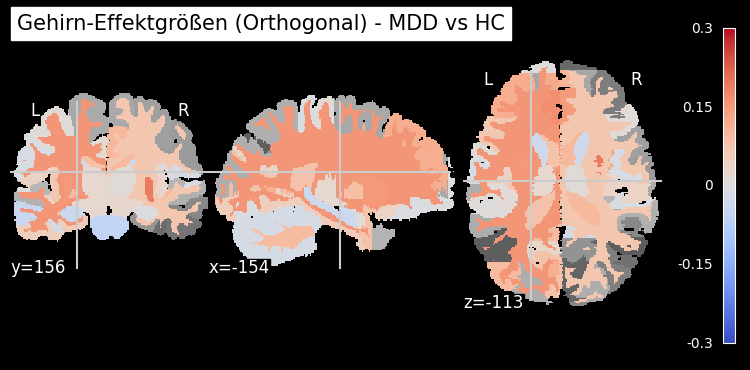


Erstelle interaktive 3D-Visualisierung für MDD vs HC (öffnet im Browser oder Inline-Fenster)...


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für MDD gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_MDD_interactive.html
ROI-Namen aus Label-Map normalisiert.


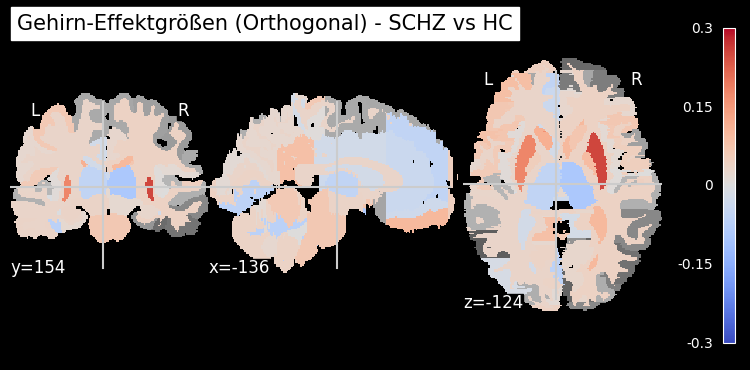


Erstelle interaktive 3D-Visualisierung für SCHZ vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für SCHZ gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_SCHZ_interactive.html
ROI-Namen aus Label-Map normalisiert.


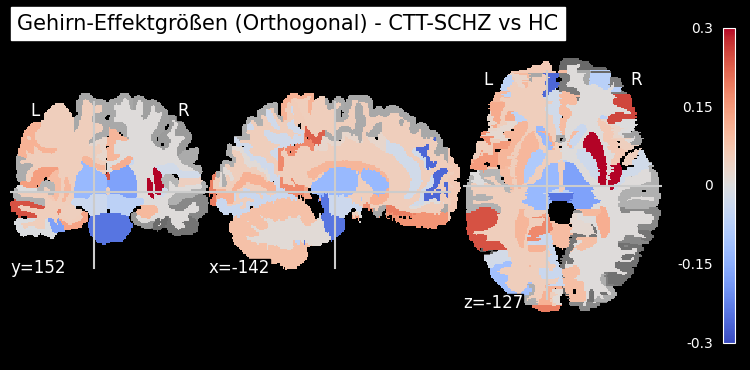


Erstelle interaktive 3D-Visualisierung für CTT-SCHZ vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-SCHZ gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-SCHZ_interactive.html
ROI-Namen aus Label-Map normalisiert.


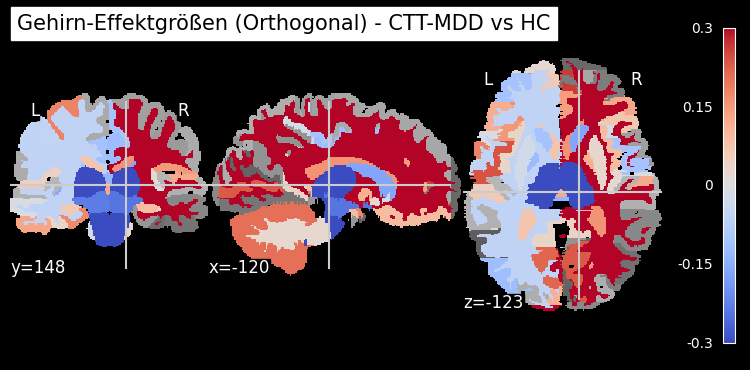


Erstelle interaktive 3D-Visualisierung für CTT-MDD vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-MDD gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-MDD_interactive.html
ROI-Namen aus Label-Map normalisiert.


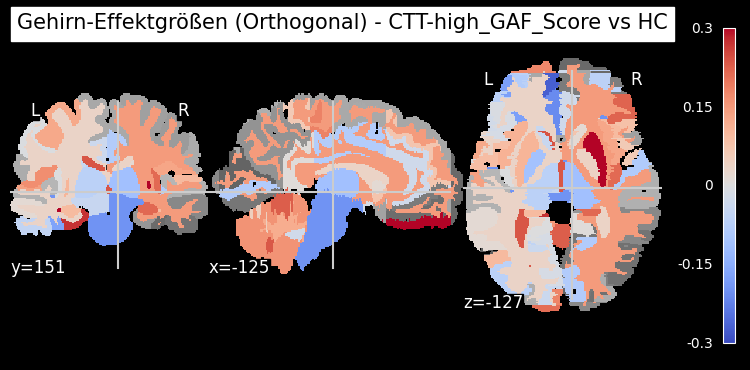


Erstelle interaktive 3D-Visualisierung für CTT-high_GAF_Score vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_GAF_Score gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_GAF_Score_interactive.html
ROI-Namen aus Label-Map normalisiert.


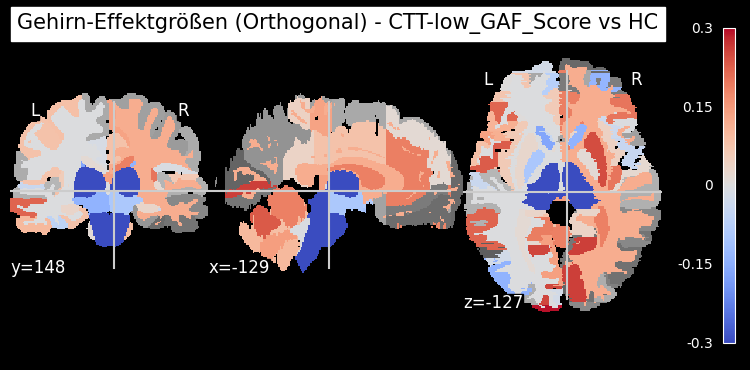


Erstelle interaktive 3D-Visualisierung für CTT-low_GAF_Score vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_GAF_Score gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_GAF_Score_interactive.html
ROI-Namen aus Label-Map normalisiert.


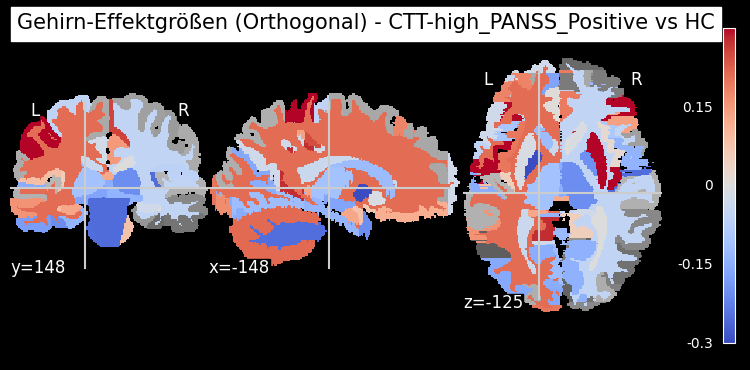


Erstelle interaktive 3D-Visualisierung für CTT-high_PANSS_Positive vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_PANSS_Positive gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_PANSS_Positive_interactive.html
ROI-Namen aus Label-Map normalisiert.


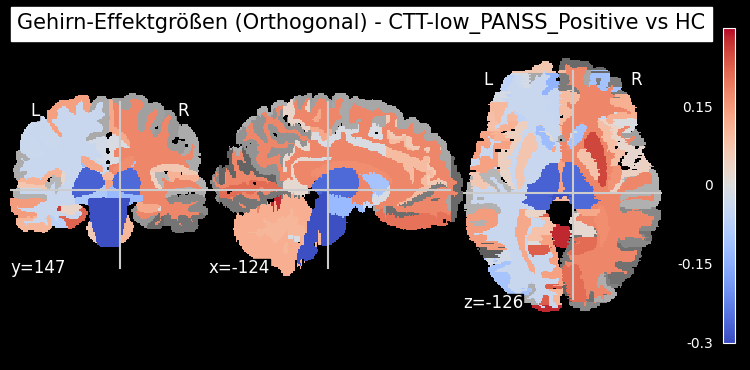


Erstelle interaktive 3D-Visualisierung für CTT-low_PANSS_Positive vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_PANSS_Positive gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_PANSS_Positive_interactive.html
ROI-Namen aus Label-Map normalisiert.


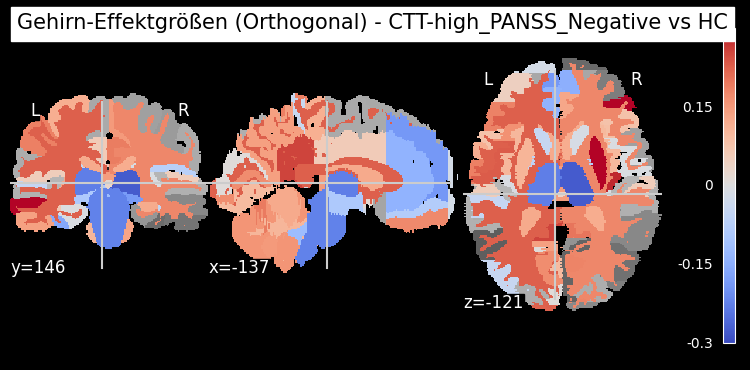


Erstelle interaktive 3D-Visualisierung für CTT-high_PANSS_Negative vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_PANSS_Negative gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_PANSS_Negative_interactive.html
ROI-Namen aus Label-Map normalisiert.


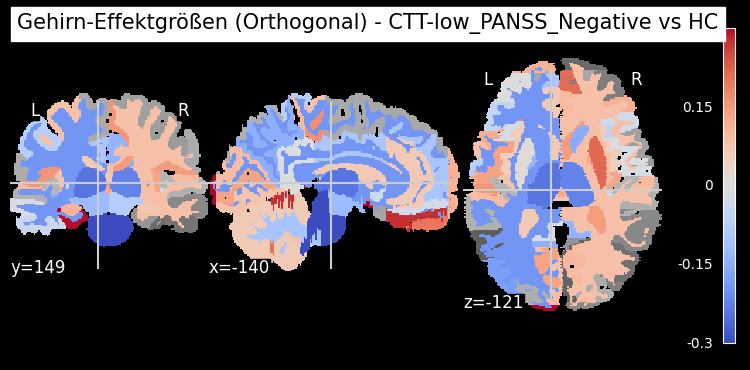


Erstelle interaktive 3D-Visualisierung für CTT-low_PANSS_Negative vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_PANSS_Negative gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_PANSS_Negative_interactive.html
ROI-Namen aus Label-Map normalisiert.


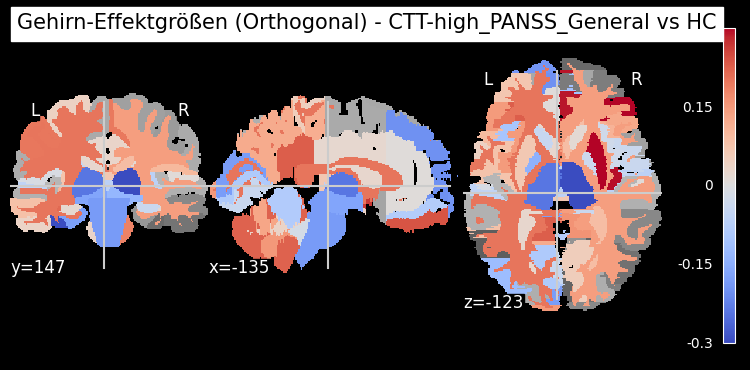


Erstelle interaktive 3D-Visualisierung für CTT-high_PANSS_General vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_PANSS_General gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_PANSS_General_interactive.html
ROI-Namen aus Label-Map normalisiert.


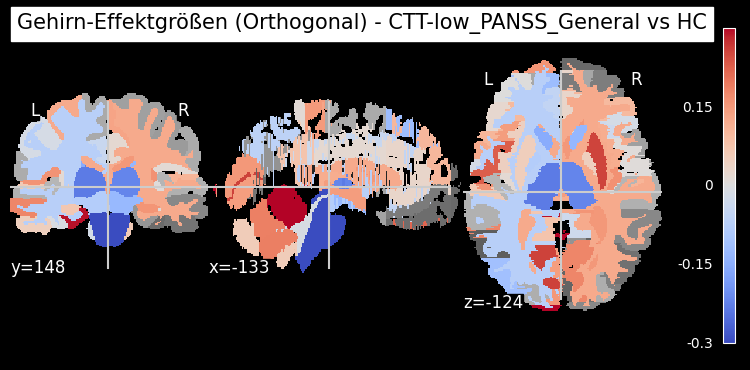


Erstelle interaktive 3D-Visualisierung für CTT-low_PANSS_General vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_PANSS_General gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_PANSS_General_interactive.html
ROI-Namen aus Label-Map normalisiert.


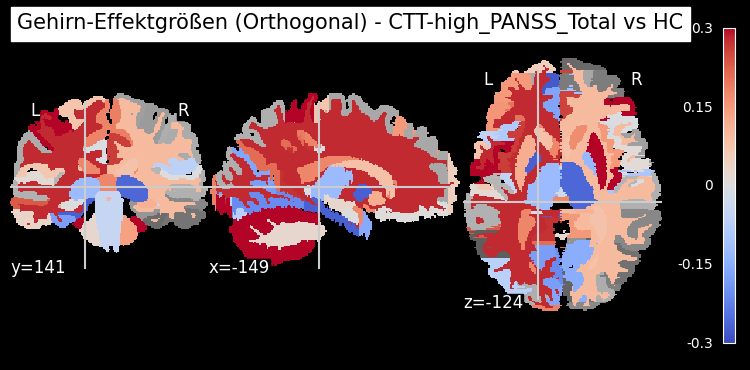


Erstelle interaktive 3D-Visualisierung für CTT-high_PANSS_Total vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_PANSS_Total gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_PANSS_Total_interactive.html
ROI-Namen aus Label-Map normalisiert.


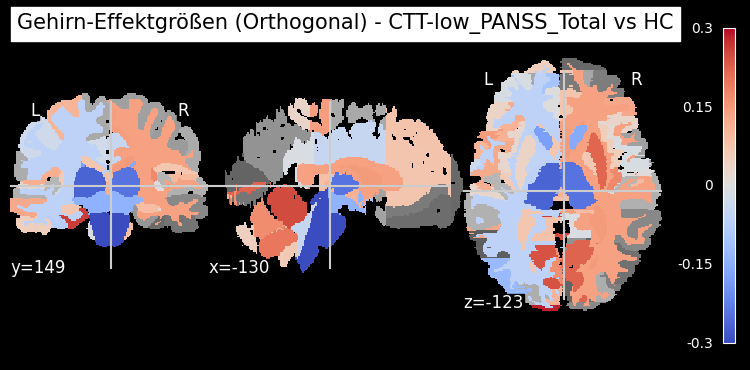


Erstelle interaktive 3D-Visualisierung für CTT-low_PANSS_Total vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_PANSS_Total gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_PANSS_Total_interactive.html
ROI-Namen aus Label-Map normalisiert.


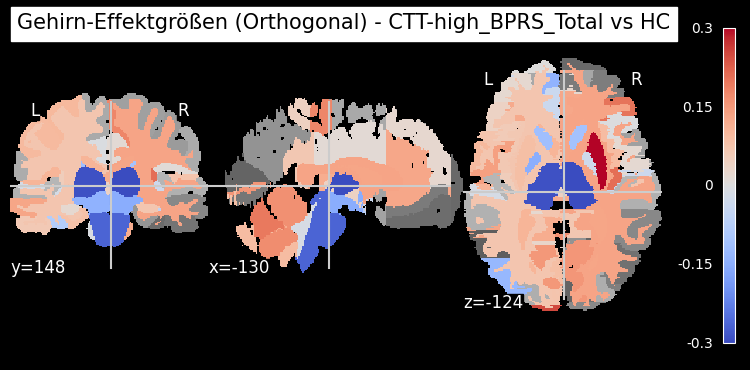


Erstelle interaktive 3D-Visualisierung für CTT-high_BPRS_Total vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_BPRS_Total gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_BPRS_Total_interactive.html
ROI-Namen aus Label-Map normalisiert.


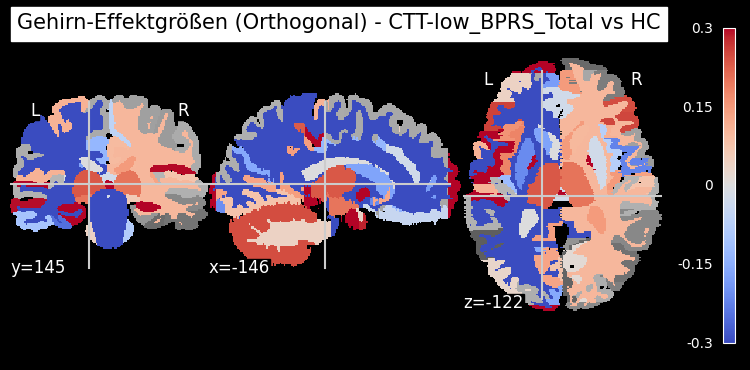


Erstelle interaktive 3D-Visualisierung für CTT-low_BPRS_Total vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_BPRS_Total gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_BPRS_Total_interactive.html
ROI-Namen aus Label-Map normalisiert.


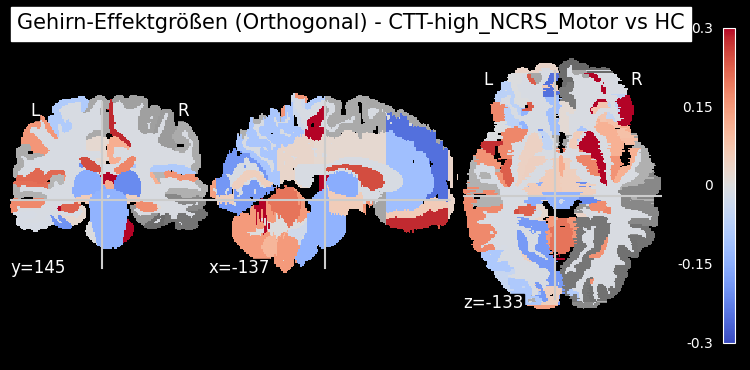


Erstelle interaktive 3D-Visualisierung für CTT-high_NCRS_Motor vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_NCRS_Motor gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_NCRS_Motor_interactive.html
ROI-Namen aus Label-Map normalisiert.


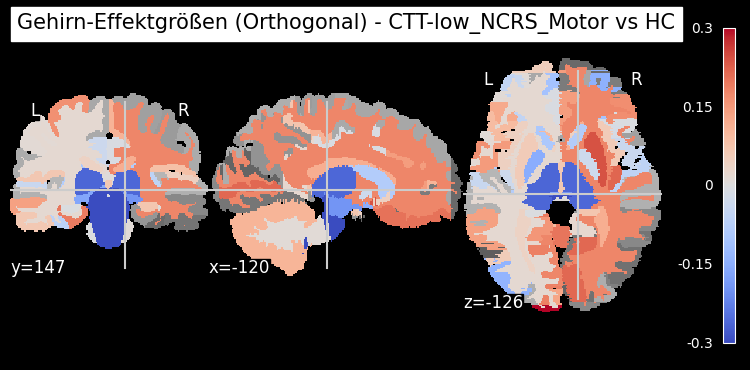


Erstelle interaktive 3D-Visualisierung für CTT-low_NCRS_Motor vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_NCRS_Motor gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_NCRS_Motor_interactive.html
ROI-Namen aus Label-Map normalisiert.


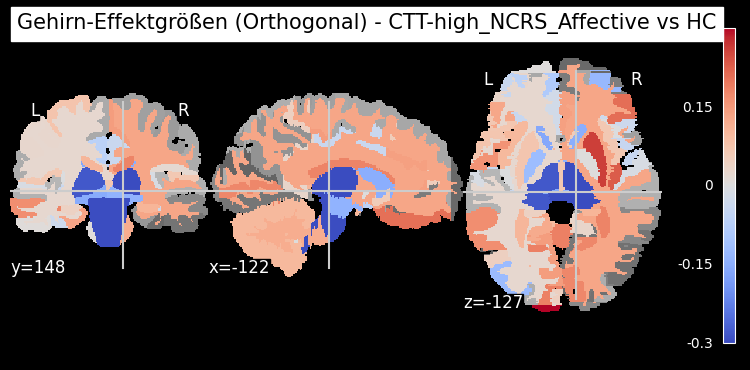


Erstelle interaktive 3D-Visualisierung für CTT-high_NCRS_Affective vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_NCRS_Affective gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_NCRS_Affective_interactive.html
ROI-Namen aus Label-Map normalisiert.


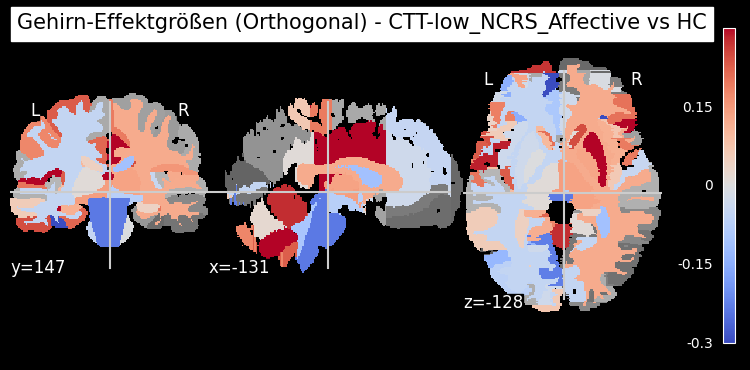


Erstelle interaktive 3D-Visualisierung für CTT-low_NCRS_Affective vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_NCRS_Affective gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_NCRS_Affective_interactive.html
ROI-Namen aus Label-Map normalisiert.


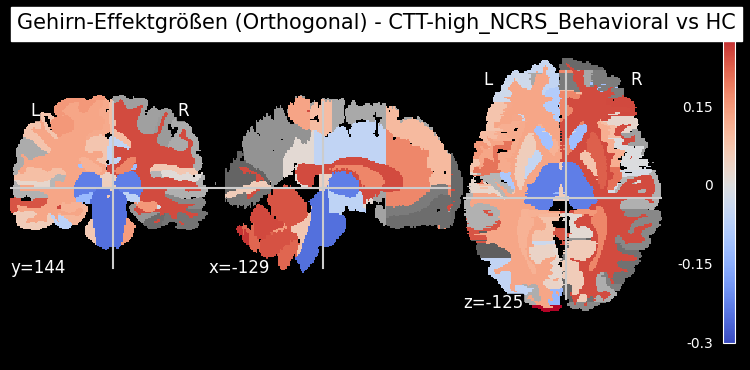


Erstelle interaktive 3D-Visualisierung für CTT-high_NCRS_Behavioral vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_NCRS_Behavioral gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_NCRS_Behavioral_interactive.html
ROI-Namen aus Label-Map normalisiert.


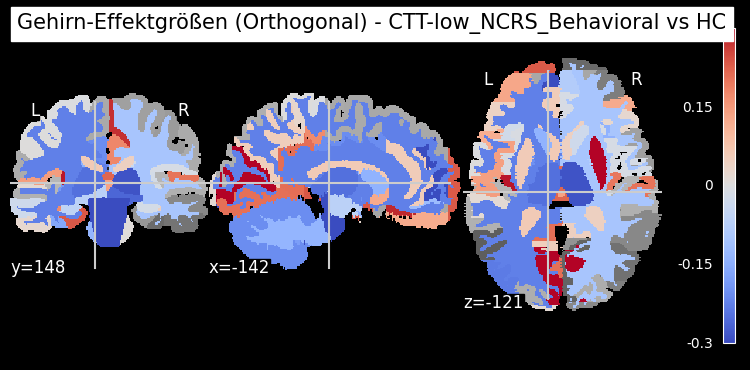


Erstelle interaktive 3D-Visualisierung für CTT-low_NCRS_Behavioral vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_NCRS_Behavioral gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_NCRS_Behavioral_interactive.html
ROI-Namen aus Label-Map normalisiert.


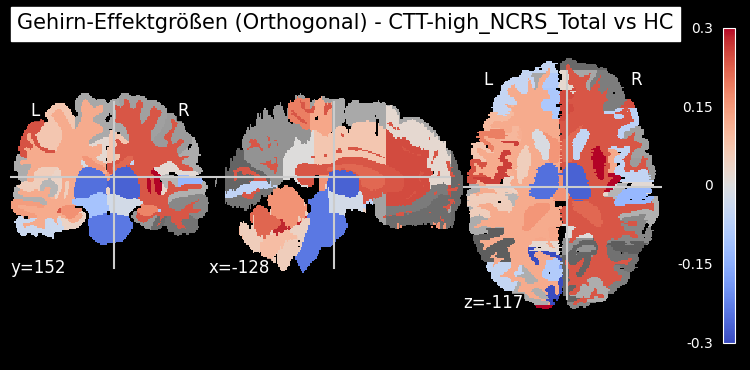


Erstelle interaktive 3D-Visualisierung für CTT-high_NCRS_Total vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_NCRS_Total gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_NCRS_Total_interactive.html
ROI-Namen aus Label-Map normalisiert.


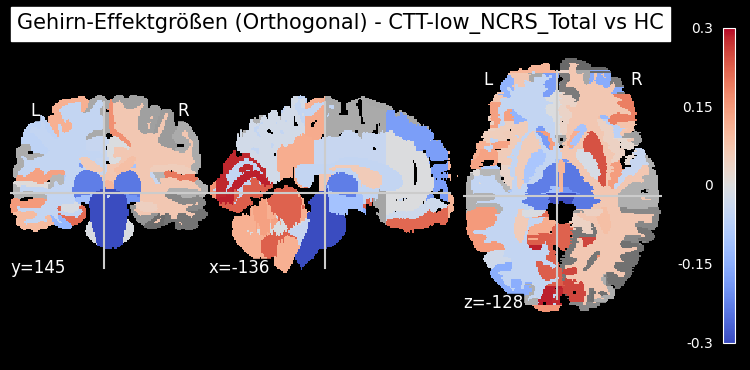


Erstelle interaktive 3D-Visualisierung für CTT-low_NCRS_Total vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_NCRS_Total gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_NCRS_Total_interactive.html
ROI-Namen aus Label-Map normalisiert.


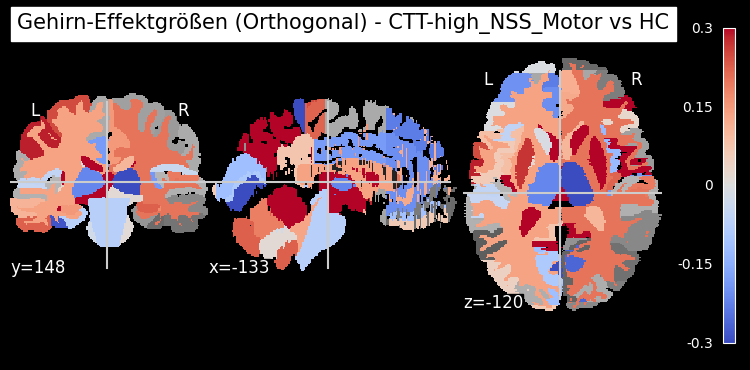


Erstelle interaktive 3D-Visualisierung für CTT-high_NSS_Motor vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_NSS_Motor gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_NSS_Motor_interactive.html
ROI-Namen aus Label-Map normalisiert.


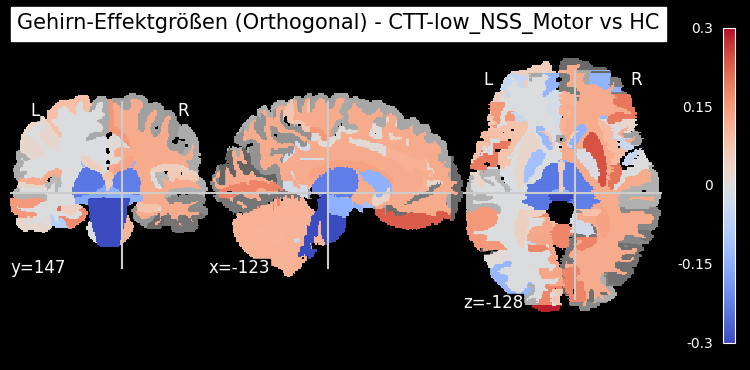


Erstelle interaktive 3D-Visualisierung für CTT-low_NSS_Motor vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_NSS_Motor gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_NSS_Motor_interactive.html
ROI-Namen aus Label-Map normalisiert.


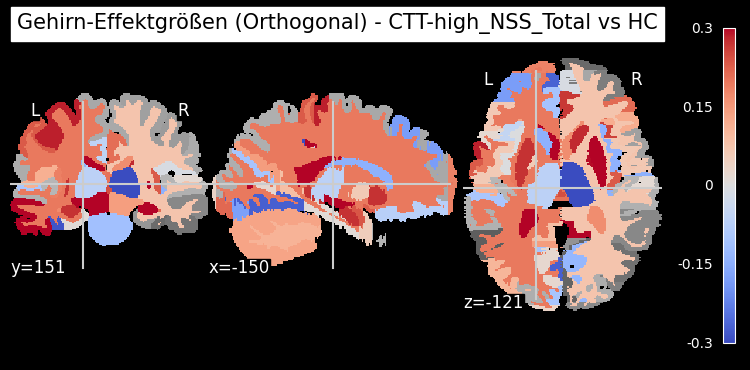


Erstelle interaktive 3D-Visualisierung für CTT-high_NSS_Total vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_NSS_Total gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_NSS_Total_interactive.html
ROI-Namen aus Label-Map normalisiert.


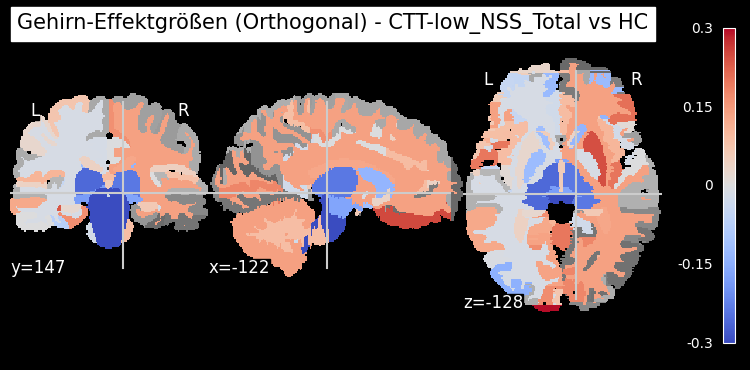


Erstelle interaktive 3D-Visualisierung für CTT-low_NSS_Total vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_NSS_Total gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_NSS_Total_interactive.html

Alle Plots abgeschlossen.


In [6]:

if __name__ == '__main__':
    neuro_morphometrics_atlas_path = "/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/neuromorphometrics.nii"
    label_map_xml_path = '/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/atlases_labels/1103_3_glm_LabelMap.xml'
    my_actual_effect_sizes_csv_path = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/CTT(MDD_SCHZ)/deviation_results_norm_results_HC_V_g_m_neuromorphometrics_cobra_lpba40_20250606_0349_20250618_132436/effect_sizes_HC.csv"

    # Define the diagnosis column nam
    diagnosis_column_name = 'Diagnosis' # <--- Make sure this matches your CSV column name exactly

    print("\n--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---")
    all_effect_sizes_df = prepare_effect_sizes_dataframe(
        effect_sizes_file_path=my_actual_effect_sizes_csv_path,
        file_type='csv',
        raw_roi_name_col='ROI_Name',
        effect_size_col='Cliffs_Delta',
        diagnosis_col=diagnosis_column_name, # Pass the diagnosis column name
        target_atlas_name="neuromorphometrics"
    )

    if all_effect_sizes_df is not None and not all_effect_sizes_df.empty:
        # Identify unique diagnoses, excluding 'HC'
        norm_diagnosis = 'HC'
        unique_diagnoses = all_effect_sizes_df[diagnosis_column_name].unique()
        diagnoses_to_plot = [d for d in unique_diagnoses if d != norm_diagnosis]

        if not diagnoses_to_plot:
            print(f"Keine anderen Diagnosen als '{norm_diagnosis}' zum Plotten gefunden.")
        else:
            #print(f"\n--- Starte Plotting für folgende Diagnosen: {', '.join(diagnoses_to_plot)} ---")
            output_dir = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots"
            os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist

            for diagnosis in diagnoses_to_plot:
                #print(f"\n### Plotting für Diagnose: {diagnosis} ###")
                df_for_diagnosis = all_effect_sizes_df[all_effect_sizes_df[diagnosis_column_name] == diagnosis].copy()

                if df_for_diagnosis.empty:
                    print(f"Keine Daten für Diagnose '{diagnosis}'. Überspringe Plot.")
                    continue

                # Generate a filename prefix for the current diagnosis
                current_output_prefix = os.path.join(output_dir, f"neuromorphometrics_effect_sizes_{diagnosis.replace(' ', '_')}")

                interactive_viewer = plot_brain_with_effect_sizes_neuromorphometrics(
                    atlas_nifti_path=neuro_morphometrics_atlas_path,
                    label_map_xml_path=label_map_xml_path,
                    effect_sizes_df_cleaned=df_for_diagnosis,
                    roi_name_col_cleaned='ROI_Name',
                    effect_size_col='Cliffs_Delta',
                    title_suffix=f"{diagnosis} vs {norm_diagnosis}", # Title includes diagnosis
                    output_filename_prefix=current_output_prefix,
                    cmap='coolwarm',
                    vmax=0.3,
                    plot_interactive=True # <--- Set to True for interactive plots
                )
                if interactive_viewer:
                    interactive_viewer.save_as_html(f"{current_output_prefix}_interactive.html")
                    print(f"Interaktiver Plot für {diagnosis} gespeichert unter: {current_output_prefix}_interactive.html")

            print("\nAlle Plots abgeschlossen.")
    else:
        print("\nPlotting übersprungen, da es Probleme bei der Vorbereitung des Effektgrößen-DataFrames gab.")